# DepthAI - Show data from All Cameras

This notebook will demonstrate how to read frames from the rgb camera and the two depth cameras.

In [1]:
# These modules are for DepthAI.
import blobconverter
import cv2
import depthai
import numpy as np

In [2]:
# These modules will enable us to build a simple event driven UI in the Jupyter notebook.
import ipywidgets as widgets
import threading
from IPython.display import display, Image

In [3]:
# Create a pipeline that tells DepthAI what operations to perform while running.
pipeline = depthai.Pipeline()
assert pipeline is not None

In [4]:
# Add the color camera node to the pipeline.
colorCamera = pipeline.createColorCamera()
assert colorCamera is not None
# This frame will be available as the 'preview' output of the node.
colorCamera.setPreviewSize(640, 480)  
colorCamera.setInterleaved(False)

In [5]:
# Add the left camera
leftCamera = pipeline.create(depthai.node.MonoCamera)
assert leftCamera is not None
leftCamera.setBoardSocket(depthai.CameraBoardSocket.LEFT)
leftCamera.setResolution(depthai.MonoCameraProperties.SensorResolution.THE_480_P)

In [6]:
# Add the right camera
rightCamera = pipeline.create(depthai.node.MonoCamera)
assert rightCamera is not None
rightCamera.setBoardSocket(depthai.CameraBoardSocket.RIGHT)
rightCamera.setResolution(depthai.MonoCameraProperties.SensorResolution.THE_480_P)

In [7]:
# XLinkOut is a "way out" from the device. Any data you want to transfer to host need to be send via XLink.
xoutRgb = pipeline.createXLinkOut()
assert xoutRgb is not None
xoutRgb.setStreamName("rgb")

xoutLeft = pipeline.createXLinkOut()
assert xoutLeft is not None
xoutLeft.setStreamName("left")

xoutRight = pipeline.createXLinkOut()
assert xoutRight is not None
xoutRight.setStreamName("right")

# Linking camera output to XLink input, so that the frames will be sent to host.
colorCamera.preview.link(xoutRgb.input)
leftCamera.out.link(xoutLeft.input)
rightCamera.out.link(xoutRight.input)

### The Pipeline is now fully constructed.

In [14]:
# Create a function to be called in the thread that will be created in the next notebook cell.
def showVideo(button):

    # ask the device to run the pipeline.
    with depthai.Device(pipeline) as device:

        # From this point, the Device will be in "running" mode and will start sending data via XLink.
        queueRgb = device.getOutputQueue(name="rgb")
        queueLeft = device.getOutputQueue(name="left", maxSize=4, blocking=False)
        queueRight = device.getOutputQueue(name="right", maxSize=4, blocking=False)

        frameRgb = None
        frameLeft = None
        frameRight = None  

        (width, height) = (640, 480)
        
        div = 2
        fw = int(width / div)
        fh = int(height / div)

        # Main host-side application loop
        while True:

            # we try to fetch the data from nn/rgb queues.
            # tryGet() will return either the data packet or None if there isn't any.
            inRgb = queueRgb.tryGet()
            inLeft = queueLeft.tryGet()
            inRight = queueRight.tryGet()

            if inRgb is not None:
                # If the packet from RGB camera is present,
                # we're retrieving the frame in OpenCV format using getCvFrame().
                frameRgb = inRgb.getCvFrame()
                #print(frameRgb.shape)
                frameRgb = cv2.resize(frameRgb, (fw, fh))

            if inLeft is not None:
                frameLeft = inLeft.getCvFrame()
                assert frameLeft is not None
                #print(frameLeft.shape)
                frameLeft = cv2.resize(frameLeft, (fw, fh))
                frameLeft = cv2.cvtColor(frameLeft, cv2.COLOR_GRAY2BGR)

            if inRight is not None:
                frameRight = inRight.getCvFrame()
                assert frameRight is not None
                #print(frameRight.shape)
                frameRight = cv2.resize(frameRight, (fw, fh))
                frameRight = cv2.cvtColor(frameRight, cv2.COLOR_GRAY2BGR)

            # Now we have three identically sized frames, show them side by side.
            if frameRgb is not None and frameLeft is not None and frameRight is not None:
                frame = np.concatenate((frameLeft, frameRgb, frameRight), axis=1)
                _, jpg = cv2.imencode('.jpeg', frame)
                display_handle.update(Image(data=jpg.tobytes()))

            # Exit the loop if the user presses 'Stop'.
            if stopButton.value==True:
                break

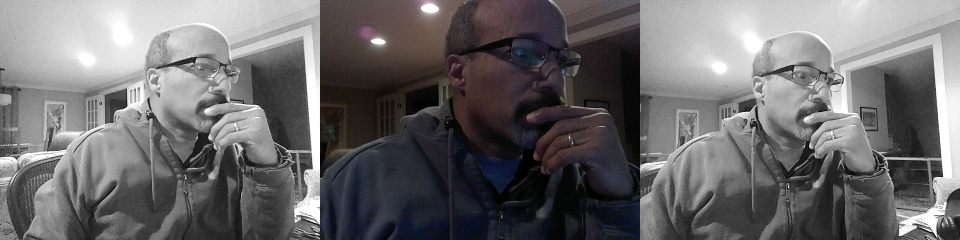

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Stop the Video')

In [16]:
# Define the button widget.
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Stop the Video',
    icon='square'
)

# Initialize the display window.
display_handle=display(None, display_id=True)
# Display the 'Stop' button.
display(stopButton)
# Create a thread that calls the showVideo() function above.
thread = threading.Thread(target=showVideo, args=(stopButton,))
thread.start()